In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_context('poster')
sns.set_color_codes("muted")

In [16]:
from langdetect import detect_langs
import pycountry as pc
import ujson as json
import itertools as it
import functools as ft
from tqdm import tqdm
from collections import namedtuple

In [3]:
with open("/media/jakob/bigdata/train/SB.json", 'rb') as cat_file:
    catalog = json.load(cat_file)

In [4]:
prediction = dict()
for page in tqdm(catalog['pages']):
    text_lines = [line['text'] for line in page['lines']]
    text = ''.join(text_lines) 
    if (len(text) > 0):
        page['languages'] = detect_langs(text)
        prediction[page['path']] =  page['languages']

100%|██████████| 4432/4432 [00:55<00:00, 80.54it/s]


In [131]:
with open("/media/jakob/bigdata/train/SB_lang.json", 'wb') as cat_file:
    json.dump(catalog, cat_file, ensure_ascii=False,indent=2, escape_forward_slashes=False)

In [3]:
with open("/media/jakob/bigdata/train/SB_lang.json", 'rb') as cat_file:
    catalog = json.load(cat_file)

In [13]:
catalog.has_key('pages')

True

In [14]:
prediction ={ page['path']: page['lang'] for page in catalog['pages'] if page.has_key('lang')}

In [19]:
prediction.values()[:20]

[[{u'lang': u'ca', u'prob': 0.9999932260000001},
  [{u'lang': u'de', u'prob': 0.9999968551}]],
 [{u'lang': u'de', u'prob': 0.9999968551}],
 [{u'lang': u'de', u'prob': 0.9999969115}],
 [{u'lang': u'ca', u'prob': 0.8571402621},
  {u'lang': u'ro', u'prob': 0.14285761930000002}],
 [{u'lang': u'de', u'prob': 0.9999962771}],
 [{u'lang': u'de', u'prob': 0.9999970922}],
 [{u'lang': u'de', u'prob': 0.9999950040000001}],
 [{u'lang': u'de', u'prob': 0.9999976507}],
 [{u'lang': u'de', u'prob': 0.8571414922},
  {u'lang': u'fr', u'prob': 0.14285768840000002}],
 [{u'lang': u'de', u'prob': 0.9999960874}],
 [{u'lang': u'de', u'prob': 0.9999948458000001}],
 [{u'lang': u'en', u'prob': 0.999997105}],
 [{u'lang': u'de', u'prob': 0.5714262158},
  {u'lang': u'it', u'prob': 0.4285695873}],
 [{u'lang': u'de', u'prob': 0.9999945615}],
 [{u'lang': u'it', u'prob': 0.9999973821}],
 [{u'lang': u'it', u'prob': 0.9999973152}],
 [{u'lang': u'de', u'prob': 0.9999959154}],
 [{u'lang': u'de', u'prob': 0.9999952544}],
 [{

# Plots

In [5]:
print detect_langs("Das ist ein Test")
print detect_langs("This ist nicht wirklich a test")

[de:0.999995484313]
[en:0.571426110365, de:0.428573889634]


In [21]:
ft.reduce(append, prediction.values(), list())

[{u'lang': u'ca', u'prob': 0.9999932260000001},
 [{u'lang': u'de', u'prob': 0.9999968551}],
 {u'lang': u'de', u'prob': 0.9999968551},
 {u'lang': u'de', u'prob': 0.9999969115},
 {u'lang': u'ca', u'prob': 0.8571402621},
 {u'lang': u'ro', u'prob': 0.14285761930000002},
 {u'lang': u'de', u'prob': 0.9999962771},
 {u'lang': u'de', u'prob': 0.9999970922},
 {u'lang': u'de', u'prob': 0.9999950040000001},
 {u'lang': u'de', u'prob': 0.9999976507},
 {u'lang': u'de', u'prob': 0.8571414922},
 {u'lang': u'fr', u'prob': 0.14285768840000002},
 {u'lang': u'de', u'prob': 0.9999960874},
 {u'lang': u'de', u'prob': 0.9999948458000001},
 {u'lang': u'en', u'prob': 0.999997105},
 {u'lang': u'de', u'prob': 0.5714262158},
 {u'lang': u'it', u'prob': 0.4285695873},
 {u'lang': u'de', u'prob': 0.9999945615},
 {u'lang': u'it', u'prob': 0.9999973821},
 {u'lang': u'it', u'prob': 0.9999973152},
 {u'lang': u'de', u'prob': 0.9999959154},
 {u'lang': u'de', u'prob': 0.9999952544},
 {u'lang': u'de', u'prob': 0.9999962046},
 

In [22]:
def append(langs, lang): 
    langs.extend(lang)
    return langs
lang_probs = [(lang['lang'], lang['prob']) for lang in ft.reduce(append, prediction.values(), list()) if type(lang) == type(dict())]

In [24]:
language_count = sorted([(pc.languages.get(iso639_1_code=key).name, (list(group)))
for key, group in it.groupby(sorted(lang_probs), lambda lang: lang[0])], key=lambda lang: lang[1])

In [25]:
counts = [ n for lang, n in language_count]
langs  = [ lang for lang, n in language_count]

In [34]:
lang_data = pd.DataFrame(lang_probs, columns=['lang', 'prob'])
lang_sum = lang_data.groupby('lang').sum()
lang_sum.index = lang_sum.index.map(lambda key: pc.languages.get(iso639_1_code=key).name)
lang_sum.sort_values('prob',ascending=False, inplace=True)
lang_sum['relative'] = lang_sum['prob'] * 100.0 / lang_sum['prob'].sum() 
# lang_sum.head()
# lang_sum.index

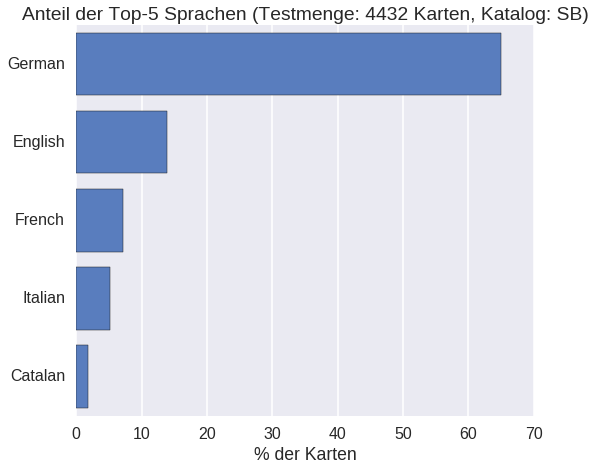

In [46]:
fig = plt.figure(figsize=(8.2, 7),)
g = sns.barplot(data=lang_sum[:5], x='relative', y=lang_sum.index[:5], color='b')
g.axes.set(xlabel='% der Karten')
g.set_title("Anteil der Top-5 Sprachen (Testmenge: {} Karten, Katalog: {})".format(len(catalog['pages']), catalog['name']))
fig.savefig('../plots/sprachverteilung.jpg', dpi=150)